In [1]:
from datasets import Dataset
from include.utils import *
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from transformers import AdamW, DistilBertForSequenceClassification, DistilBertTokenizerFast, EarlyStoppingCallback, Trainer, TrainingArguments

import matplotlib.pyplot as plt
import numpy as np
import os
import warnings

**Objetivo**

Preparar e ajustar um modelo DistilBERT pré-treinado para realizar a classificação de textos com base em um conjunto de dados específico.

Utilizaremos o DistilBERT, uma versão otimizada e mais leve do BERT, para realizar a tarefa de classificação de textos. O fine-tuning será realizado para aprimorar a precisão e a consistência do modelo com base no estilo e nas características dos documentos fornecidos.

**Preparação dos dados**

Carregamos os dados de um arquivo Parquet e verificamos se a coluna de rótulos está presente. Caso não esteja, geramos rótulos sintéticos para possibilitar o treinamento do modelo. Em seguida, aplicamos uma amostragem opcional para limitar o tamanho do dataset, facilitando o teste inicial e a validação do fluxo de trabalho.

In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)

diretorio_arquivos = '../arquivos'
parquet_file_path = os.path.join(diretorio_arquivos, 'trn.parquet')
diretorio_finetunning_results = os.path.join(diretorio_arquivos, 'finetunning', 'results')
diretorio_finetunning_logs = os.path.join(diretorio_arquivos, 'finetunning', 'logs')
diretorio_finetunning_modelo_final = os.path.join(diretorio_arquivos, 'finetunning', 'modelo_final')
processed_indices_file_path = os.path.join(diretorio_arquivos, 'finetunning', 'processed_indices.npy')

# Carregar DataFrame do Parquet
dados = load_dataframe(parquet_file_path)

# Gerando rótulo sintético
if 'label' not in dados.columns:
    np.random.seed(42)  # Para reprodutibilidade
    dados['label'] = np.random.randint(0, 2, size=len(dados))

# Configurações de amostragem e processamento
batch_size = 5250
use_sample = True

# Determinar o índice inicial para processamento
start_idx = 0
if os.path.exists(processed_indices_file_path):
    start_idx = np.load(processed_indices_file_path).item()
    print(f"Continuando o processamento a partir do índice {start_idx}.")
else:
    print("Iniciando processamento do início.")

# Ajustando textos quando usado amostras
if use_sample:
    end_idx = min(start_idx + batch_size, len(dados))
    dados = dados.iloc[start_idx:end_idx]
    print(f"Usando uma amostra de {len(dados)} registros.")
else:
    dados = dados.iloc[start_idx:]

Continuando o processamento a partir do índice 71610.
Usando uma amostra de 5250 registros.


**Pré-Processamento dos Dados**

Utilizamos o tokenizador DistilBERT para processar os textos, combinando título e descrição e aplicando truncamento e padding conforme necessário. Convertendo o DataFrame para um Dataset e preparamos os dados para o treinamento do modelo.

In [3]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

def preprocess_function(examples):
    # Combinar título e descrição
    combined_text = [f"Título: {title} Descrição: {content}" for title, content in zip(examples['title'], examples['content'])]
    return tokenizer(combined_text, truncation=True, padding='max_length', max_length=512)

# Converter DataFrame para Dataset
def convert_to_dataset(df):
    # Aplicar a função de pré-processamento a todos os textos
    encodings = preprocess_function({'title': df['title'].tolist(), 'content': df['content'].tolist()})
    encodings['label'] = df['label'].tolist()  # Adicionar rótulos
    return Dataset.from_dict(encodings)

dataset = convert_to_dataset(dados)

**Divisão do dataset**

O dataset é embaralhado e dividido em dois conjuntos: um para treinamento (80% dos dados) e outro para avaliação (20% dos dados). Isso garante que o modelo seja treinado e testado em dados distintos para uma avaliação justa do seu desempenho.

In [4]:
# Dividir o dataset em treino e avaliação
dataset = dataset.shuffle(seed=42)
train_size = int(0.8 * len(dataset))
eval_size = len(dataset) - train_size
train_dataset = dataset.select(range(train_size))
eval_dataset = dataset.select(range(train_size, train_size + eval_size))

**Carregamento do modelo**

Carregamos o modelo DistilBERT pré-treinado para classificação de sequência, ajustando-o para o número de rótulos no nosso dataset.

In [5]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(set(dados['label'])))
print(f"Modelo inicial carregado.")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modelo inicial carregado.


**Configuração do modelo e argumentos de treinamento**

Inicializamos o modelo DistilBERT para classificação de sequência e configuramos os parâmetros de treinamento, incluindo o número de épocas, tamanhos de lote, e estratégias de avaliação e salvamento. Estas configurações ajudam a otimizar o processo de fine-tuning, adaptando o treinamento para o modelo e os dados específicos.

In [6]:
optimizer = AdamW(model.parameters(), lr=3e-5)

training_args = TrainingArguments(
    output_dir=diretorio_finetunning_results,
    num_train_epochs=3,                        # 1 época para testes rápidos
    per_device_train_batch_size=16,            # Reduzir o batch size para liberar mais memória
    per_device_eval_batch_size=16,             # Avaliação também com batch pequeno
    warmup_steps=0,                            # Remover warmup
    weight_decay=0.01,                         # Decaimento de peso
    logging_dir=None,                          # Desativar logs
    logging_steps=-1,                          # Desativar logs frequentes
    eval_strategy='steps',                     # Avaliar a cada X passos
    save_strategy='steps',                     # Salvar a cada X passos
    save_steps=200000,                         # Salvar menos frequente
    eval_steps=200000,                         # Avaliar menos frequente
    load_best_model_at_end=True,               # Carregar o melhor modelo no final
    save_safetensors=True,                     # Serialização segura
    dataloader_num_workers=0,                  # Menos workers para aliviar a CPU
    fp16=False,                                # Não usar FP16 em CPU
    report_to=None,                            # Desativar relatórios de monitoramento (Ex: TensorBoard)
    resume_from_checkpoint=True                # Retomar de um checkpoint anterior
)

**Treinamento, avaliação e salvamento do modelo**

Realizamos o treinamento do modelo, monitorando o progresso a cada época com a ajuda de um callback para early stopping. Após cada época, avaliamos o desempenho do modelo, armazenamos as métricas de avaliação, e salvamos o modelo atualizado. Além disso, mantemos o índice de progresso atualizado para continuar o treinamento em execuções futuras, e paar seguir no RAG.

In [7]:
# Configurar o callback para early stopping
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=2)

# Adicionar o callback ao seu treinamento
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    callbacks=[early_stopping_callback],
    optimizers=(optimizer, None)  # Passar o otimizador AdamW
)

# Verificar o estado do modelo antes do treinamento
"""
Comentado para reduzir o tempo de rodagem. Sendo descomentado algumas vezes para acompanhamento inicial

initial_results = {}
if os.path.exists(diretorio_finetunning_modelo_final):
    initial_results = trainer.evaluate()
print(f"Estado inicial do modelo: {initial_results}")
"""

# Lista para armazenar os valores de loss e epoch
eval_losses = []
epochs = []

# Treinamento com Progress
for epoch in range(int(training_args.num_train_epochs)):
    trainer.train(resume_from_checkpoint=True)
    tqdm.write(f'Epoch {epoch+1}/{int(training_args.num_train_epochs)} complete.')
    
    # Avaliar o modelo
    results = trainer.evaluate()

    # Armazenar eval_loss e epoch
    eval_losses.append(results['eval_loss'])
    epochs.append(epoch + 1)
    
    # Imprimir resultados da avaliação após cada época
    print(f'Results após Epoch {epoch+1}: {results}')

    # Salvar o modelo
    trainer.save_model(diretorio_finetunning_modelo_final)
    print(f"Modelo salvo em '{diretorio_finetunning_modelo_final}'.")

    # Atualizar índice processado
    np.save(processed_indices_file_path, end_idx)
    print(f"Índice processado atualizado: {end_idx}")

Step,Training Loss,Validation Loss


Epoch 1/3 complete.


Results após Epoch 1: {'eval_loss': 0.6939905285835266, 'eval_runtime': 339.9666, 'eval_samples_per_second': 3.089, 'eval_steps_per_second': 0.194, 'epoch': 3.0}
Modelo salvo em '../arquivos\finetunning\modelo_final'.
Índice processado atualizado: 76860


Step,Training Loss,Validation Loss


Epoch 2/3 complete.
Results após Epoch 2: {'eval_loss': 0.6939905285835266, 'eval_runtime': 358.4334, 'eval_samples_per_second': 2.929, 'eval_steps_per_second': 0.184, 'epoch': 3.0}
Modelo salvo em '../arquivos\finetunning\modelo_final'.
Índice processado atualizado: 76860


Step,Training Loss,Validation Loss


Epoch 3/3 complete.
Results após Epoch 3: {'eval_loss': 0.6939905285835266, 'eval_runtime': 443.8293, 'eval_samples_per_second': 2.366, 'eval_steps_per_second': 0.149, 'epoch': 3.0}
Modelo salvo em '../arquivos\finetunning\modelo_final'.
Índice processado atualizado: 76860


**Gráfico**

Geramos um gráfico para visualizar a variação do loss durante o treinamento do modelo. O gráfico mostra o loss em função das épocas, facilitando a análise do desempenho do modelo ao longo do tempo.

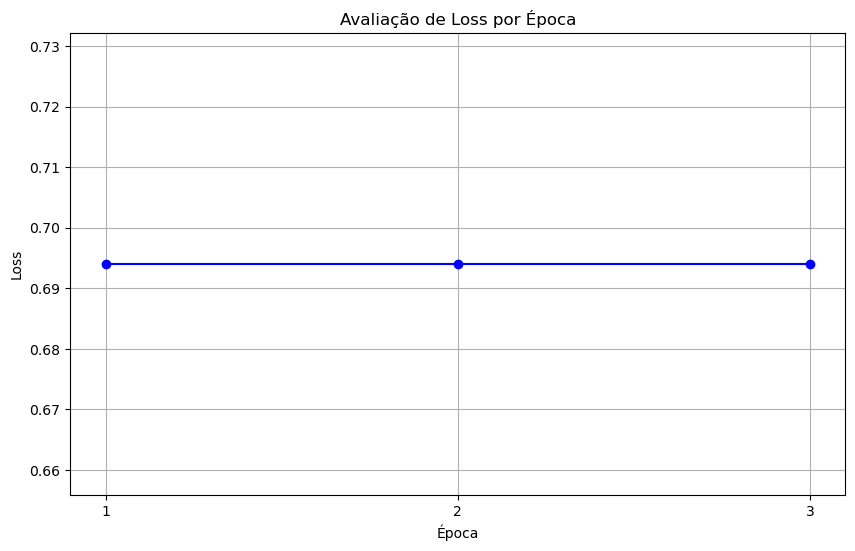

In [8]:
# Plotar o gráfico
plt.figure(figsize=(10, 6))
plt.plot(epochs, eval_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Avaliação de Loss por Época')
plt.grid(True)
plt.xticks(range(1, int(training_args.num_train_epochs) + 1))
plt.show()